<a href="https://colab.research.google.com/github/Stella-kimani/Flight-delay-Prediction/blob/main/Flight__Delay_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flight delays not only irritate air passengers and disrupt their schedules but also cause :

a decrease in efficiency
an increase in capital costs, reallocation of flight crews and aircraft
an additional crew expenses
As a result, on an aggregate basis, an airline's record of flight delays may have a negative impact on passenger demand.

This project aims to predict the estimated duration of flight delays per flight

This solution proposes to build a flight delay predictive model using Machine Learning techniques. The accurate prediction of flight delays will help all players in the air travel ecosystem to set up effective action plans to reduce the impact of the delays and avoid loss of time, capital and resources.

Variable definitions

DATOP - Date of flight

FLTID - Flight number

DEPSTN - Departure point

ARRSTN - Arrival point

STD - Scheduled Time departure

STA - Scheduled Time arrival

STATUS - Flight status

ETD - Expected Time departure

ETA - Expected Time arrival

ATD - Actual Time of Departure

ATA - Actual Time of arrival

DELAY1 - Delay code 1

DUR1 - delay time 1

DELAY2 - Delay code 2

DUR2 - delay time 2

DELAY3 - Delay code 3

DUR3 - delay time 3

DELAY4 - Delay code 4

DUR4 - delay time 4

AC - Aircraft Code

In [50]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
!pip -qq install catboost
import datetime 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score

In [4]:
#importing Dataset
train=pd.read_csv('/content/Train.csv')
train.head()


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [5]:
test = pd.read_csv('/content/Test.csv')
test.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07.30.00,ATA,TU 32AIMF
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20.05.00,ATA,TU 320IMW
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12.25.00,ATA,TU 32AIMC
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13.10.00,ATA,TU 31BIMO
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12.35.00,ATA,TU 736IOQ


In [6]:
# Checking for the shape  of the train and test dataframes

print(f'The train shape is {train.shape} and the test shape is {test.shape}')

The train shape is (107833, 10) and the test shape is (9333, 9)


In [7]:
# Check for duplicates
print(f'Are there duplicates in train data? {train.duplicated().any()},and are there duplicates in test data? {test.duplicated().any()}')


Are there duplicates in train data? False,and are there duplicates in test data? False


In [ ]:
# Checking for the null values of the train data
train.isnull().any()


ID        False
DATOP     False
FLTID     False
DEPSTN    False
ARRSTN    False
STD       False
STA       False
STATUS    False
AC        False
target    False
dtype: bool

In [ ]:
# Previweing  information about the dataframe

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


Most of the columns have incorrect datatypes, we will need to convert them into the correct datatypes during cleaning

In [ ]:
# Previweing  information about the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      9333 non-null   object
 1   DATOP   9333 non-null   object
 2   FLTID   9333 non-null   object
 3   DEPSTN  9333 non-null   object
 4   ARRSTN  9333 non-null   object
 5   STD     9333 non-null   object
 6   STA     9333 non-null   object
 7   STATUS  9333 non-null   object
 8   AC      9333 non-null   object
dtypes: object(9)
memory usage: 656.4+ KB


**Data Wrangling and cleaning**

In [8]:
# converting the incorrect datatypes to right data types
train['DATOP'] = pd.to_datetime(train['DATOP'])
train['FLTID'] = train['FLTID'].astype('category')
train['DEPSTN'] = train['DEPSTN'].astype('category')
train['ARRSTN'] = train['ARRSTN'].astype('category')
train['STD'] = pd.to_datetime(train['STD'])
train['STA'] = train['STA'].str.replace('.', ':') # replacing period with column to get the time column in to the right format
train['STA'] = pd.to_datetime(train['STA'])
train['STATUS'] = train['STATUS'].astype('category')
train['AC'] = train['AC'].astype('category')


In [9]:
# converting the incorrect datatypes to right data types

test['DATOP'] = pd.to_datetime(test['DATOP'])
test['FLTID'] = test['FLTID'].astype('category')
test['DEPSTN'] = test['DEPSTN'].astype('category')
test['ARRSTN'] = test['ARRSTN'].astype('category')
test['STD'] = pd.to_datetime(test['STD'])
test['STA'] = test['STA'].str.replace('.', ':') # replacing period with column to get the time column in to the right format
test['STA'] = pd.to_datetime(test['STA'])
test['STATUS'] = test['STATUS'].astype('category')
test['AC'] = test['AC'].astype('category')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      107833 non-null  object        
 1   DATOP   107833 non-null  datetime64[ns]
 2   FLTID   107833 non-null  category      
 3   DEPSTN  107833 non-null  category      
 4   ARRSTN  107833 non-null  category      
 5   STD     107833 non-null  datetime64[ns]
 6   STA     107833 non-null  datetime64[ns]
 7   STATUS  107833 non-null  category      
 8   AC      107833 non-null  category      
 9   target  107833 non-null  float64       
dtypes: category(5), datetime64[ns](3), float64(1), object(1)
memory usage: 5.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ID      9333 non-null   object        
 1   DATOP   9333 non-null   datetime64[ns]
 2   FLTID   9333 non-null   category      
 3   DEPSTN  9333 non-null   category      
 4   ARRSTN  9333 non-null   category      
 5   STD     9333 non-null   datetime64[ns]
 6   STA     9333 non-null   datetime64[ns]
 7   STATUS  9333 non-null   category      
 8   AC      9333 non-null   category      
dtypes: category(5), datetime64[ns](3), object(1)
memory usage: 380.0+ KB


In [10]:
#Create a time difference column that finds the difference between the Stated time of arrival Column and Stated time of departure column
#The resulting column shows time in minutes 
%%time
time_diff = [(train.STA.loc[i] - train.STD.loc[i]).total_seconds()/60 for i in range(train.shape[0])]

CPU times: user 7.14 s, sys: 1.32 ms, total: 7.14 s
Wall time: 7.15 s


In [11]:
train['time_diff'] = time_diff #This creates a new column in train dataset
train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,time_diff
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,145.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,110.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,155.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,170.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,80.0


In [ ]:
%%time
time_diff = [(test.STA.loc[i] - test.STD.loc[i]).total_seconds()/60 for i in range(test.shape[0])] #Do the same for the test data
test['time_diff'] = time_diff


In [13]:
# Checking for anomalies in the date columns
# first we check split the dates into year, month, day , hr, and min
# splitting DATOP into year, month, day
train['year_datop'] = pd.to_datetime(train['DATOP']).dt.year
train['month_datop'] = pd.to_datetime(train['DATOP']).dt.month
train['day_datop'] = pd.to_datetime(train['DATOP']).dt.day

# splitting STD into hours and minutes
train['std_hr'] = pd.to_datetime(train['STD']).dt.hour
train['std_min'] = pd.to_datetime(train['STD']).dt.minute

# splitting STA into hours and minutes
train['sta_hr'] = pd.to_datetime(train['STA']).dt.hour
train['sta_min'] = pd.to_datetime(train['STA']).dt.minute

In [14]:
# Checking for anomalies in the date columns
# first we check split the dates into year, month, day , hr, and min
# splitting DATOP into year, month, day
test['year_datop'] = pd.to_datetime(test['DATOP']).dt.year
test['month_datop'] = pd.to_datetime(test['DATOP']).dt.month
test['day_datop'] = pd.to_datetime(test['DATOP']).dt.day

# splitting STD into hours and minutes
test['std_hr'] = pd.to_datetime(test['STD']).dt.hour
test['std_min'] = pd.to_datetime(test['STD']).dt.minute

# splitting STA into hours and minutes
test['sta_hr'] = pd.to_datetime(test['STA']).dt.hour
test['sta_min'] = pd.to_datetime(test['STA']).dt.minute

In [15]:
# More data cleaning procedures
# changing the names of columns so that they make more sense

train.rename(columns={'ID': 'id','DATOP': 'date_flight', 'FLTID': 'flight_number', 'DEPSTN': 'departure_point', 'ARRSTN': 'arrival_point', 'STD': 'scheduled_time_departure',
             'STA': 'scheduled_time_arrival', 'STATUS': 'status', 'AC': 'aircraft_code', 'target': 'delayed_minutes'}, inplace=True)

In [16]:
# More data cleaning procedures
# changing the names of columns so that they make more sense

test.rename(columns={'ID': 'id','DATOP': 'date_flight', 'FLTID': 'flight_number', 'DEPSTN': 'departure_point', 'ARRSTN': 'arrival_point', 'STD': 'scheduled_time_departure',
             'STA': 'scheduled_time_arrival', 'STATUS': 'status', 'AC': 'aircraft_code', 'target': 'delayed_minutes'}, inplace=True)

In [17]:

# Creating a function to be used to create delay or not

def Outcome(delayed_minutes):
  if delayed_minutes > 0:
    return 'delay'
  elif delayed_minutes == 0:
    return 'on time'
  else:
    return 'early'

# Applying the result function to the dataframe
train['Outcome'] = train.delayed_minutes.apply(lambda x: Outcome(x))

# Previewing the changes 
train.head(10)

,id,date_flight,flight_number,departure_point,arrival_point,scheduled_time_departure,scheduled_time_arrival,status,aircraft_code,delayed_minutes,time_diff,year_datop,month_datop,day_datop,std_hr,std_min,sta_hr,sta_min,Outcome
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,145.0,2016,1,3,10,30,12,55,delay
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,110.0,2016,1,13,15,5,16,55,delay
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,155.0,2016,1,16,4,10,6,45,on time
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,170.0,2016,1,17,14,10,17,0,on time
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,80.0,2016,1,17,14,30,15,50,delay
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18:15:00,ATA,TU 736IOP,53.0,115.0,2016,1,17,16,20,18,15,delay
6,train_id_6,2016-01-18,TU 0514,TUN,BCN,2016-01-18 07:15:00,2016-01-18 09:00:00,ATA,TU 32AIMH,10.0,105.0,2016,1,18,7,15,9,0,delay
7,train_id_7,2016-01-18,TU 0716,TUN,ORY,2016-01-18 07:35:00,2016-01-18 09:55:00,ATA,TU 32AIMI,15.0,140.0,2016,1,18,7,35,9,55,delay
8,train_id_8,2016-01-18,TU 0752,TUN,FCO,2016-01-18 07:40:00,2016-01-18 09:00:00,ATA,TU 32AIMC,16.0,80.0,2016,1,18,7,40,9,0,delay
9,train_id_9,2016-01-18,TU 0996,TUN,NCE,2016-01-18 07:45:00,2016-01-18 09:15:00,ATA,TU 31AIMK,21.0,90.0,2016,1,18,7,45,9,15,delay


In [18]:
# Creating a seasons column
df = [train, test]
for data in df:
    data.loc[ (data['month_datop'] < 3) | (data['month_datop'] == 12), 'Season'] = "Winter"
    data.loc[(data['month_datop'] >= 3) & (data['month_datop'] < 6), 'Season'] = "spring"
    data.loc[(data['month_datop'] >= 6) & (data['month_datop'] < 9), 'Season'] = "summer"
    data.loc[(data['month_datop'] >= 9) & (data['month_datop'] < 12), 'Season'] = "Autumn"
    data['Season'] = data['Season']

In [19]:
# convert to date time and the required format
# scheduled time departure column
train['scheduled_time_departure'] = pd.to_datetime(train['scheduled_time_departure'], format='%Y-%m-%d %H:%M:%S')
test['scheduled_time_departure'] = pd.to_datetime(test['scheduled_time_departure'], format='%Y-%m-%d %H:%M:%S')

# scheduled time arrival column
train['scheduled_time_arrival'] = pd.to_datetime(train['scheduled_time_arrival'], format='%Y-%m-%d %H.%M.%S')
test['scheduled_time_arrival'] = pd.to_datetime(test['scheduled_time_arrival'], format='%Y-%m-%d %H.%M.%S')

In [20]:
num_cols = ['delayed_minutes', 'year_datop',
       'month_datop', 'day_datop', 'std_hr', 'std_min', 'sta_hr', 'sta_min','time_diff']

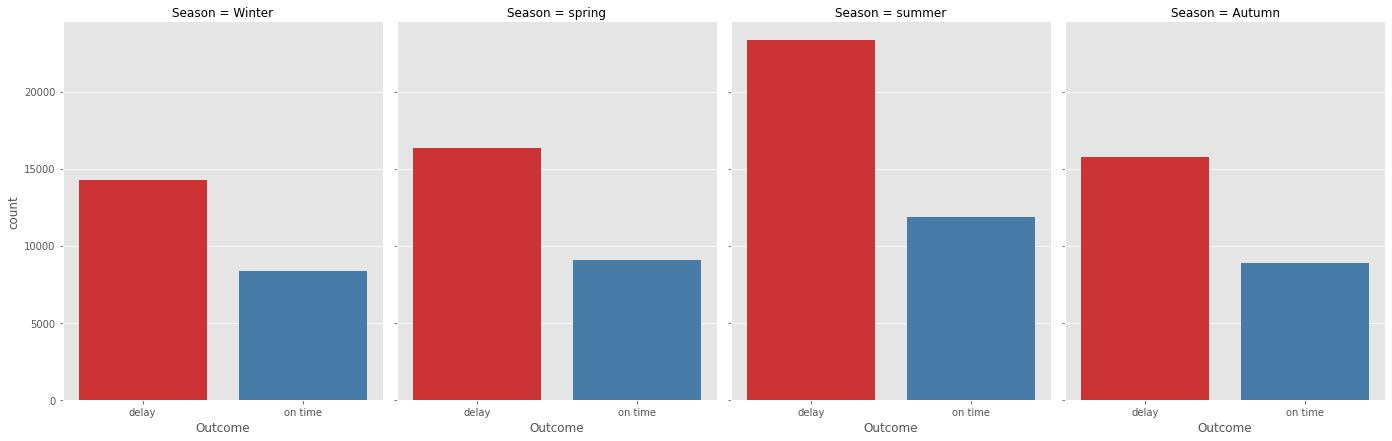

In [21]:

# Plotting  charts
#
sns.catplot("Outcome", col="Season", col_wrap=4, data=train, kind="count", height=6, aspect=.8, palette='Set1')
plt.show()

In the Winter season,more flights have not been on time and are  delayed.This is the same for Spring,Summer and Autumn seasonns.

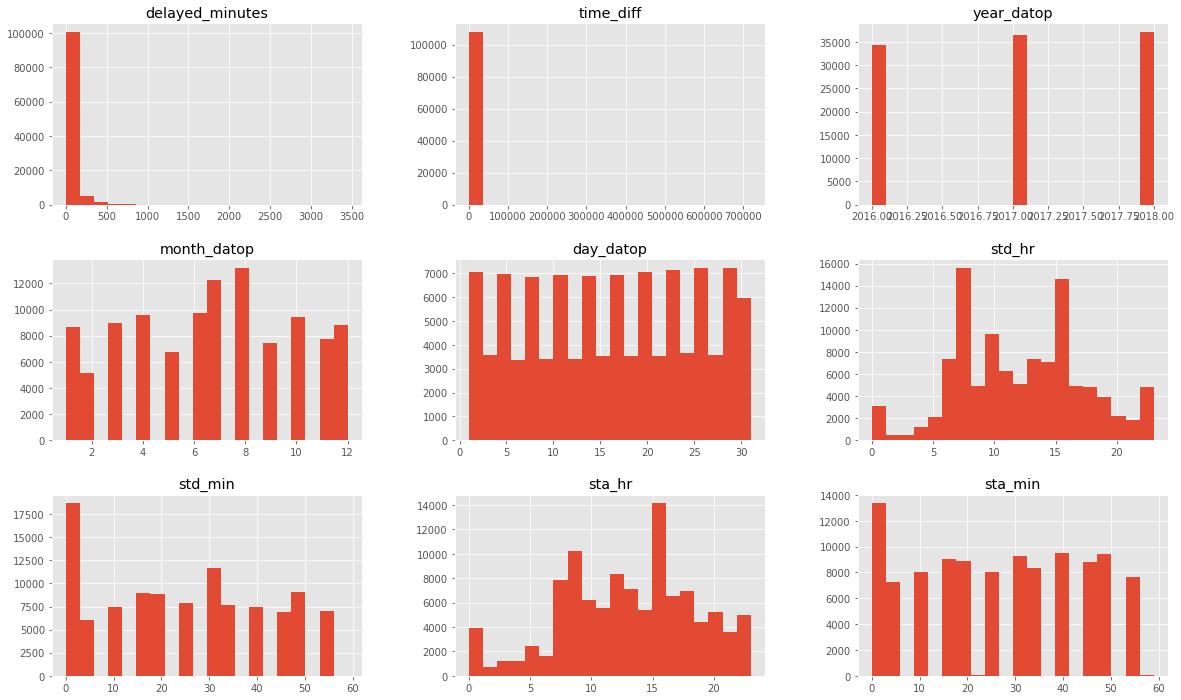

In [22]:
train.hist(bins=20, figsize=(20, 12))
plt.show()

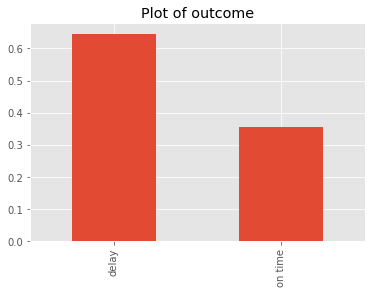

In [23]:
Count_Outcome = train.Outcome.value_counts() 
(Count_Outcome/train.shape[0]).plot(kind="bar");
plt.title("Plot of outcome");

There are more delayed flights than on time flights.

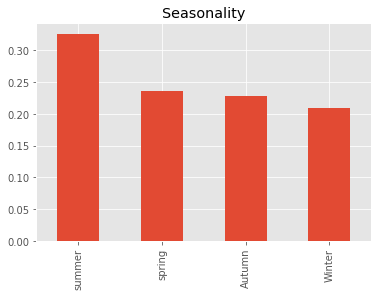

In [ ]:
#Which season has most flights
Season_vals = train.Season.value_counts()
(Season_vals/train.shape[0]).plot(kind="bar");
plt.title("Seasonality");

During Summer season there are more flights.

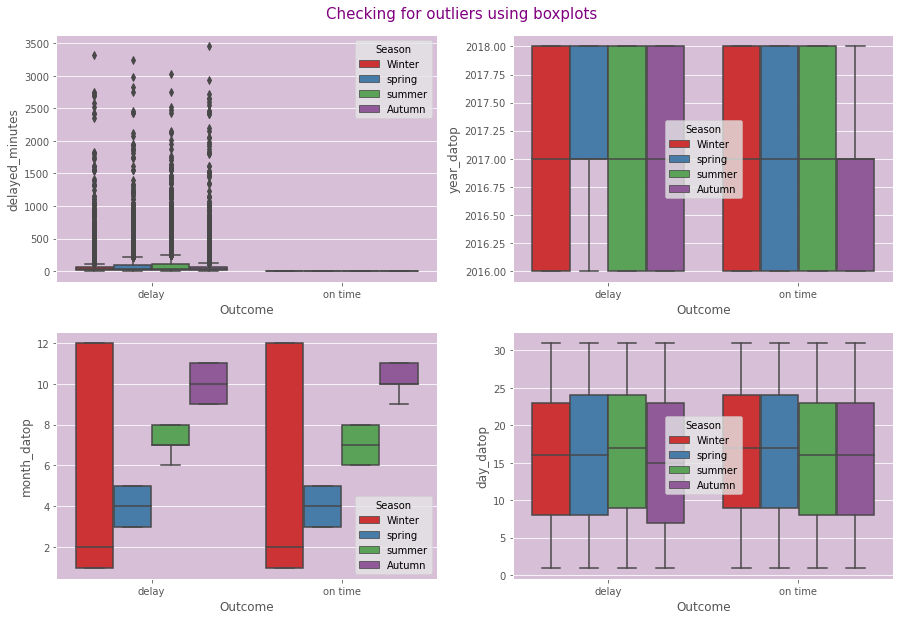

In [ ]:
# Plotting boxplots to check for outliers
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Checking for outliers using boxplots', fontsize = 15, y = 0.92, color = 'purple')
for ax, data, column in zip(axes.flatten(), train, num_cols):
  sns.boxplot(train.Outcome, train[column], ax = ax, hue = train.Season, palette = 'Set1')
  ax.set_facecolor('thistle') # Setting the background color to thistle

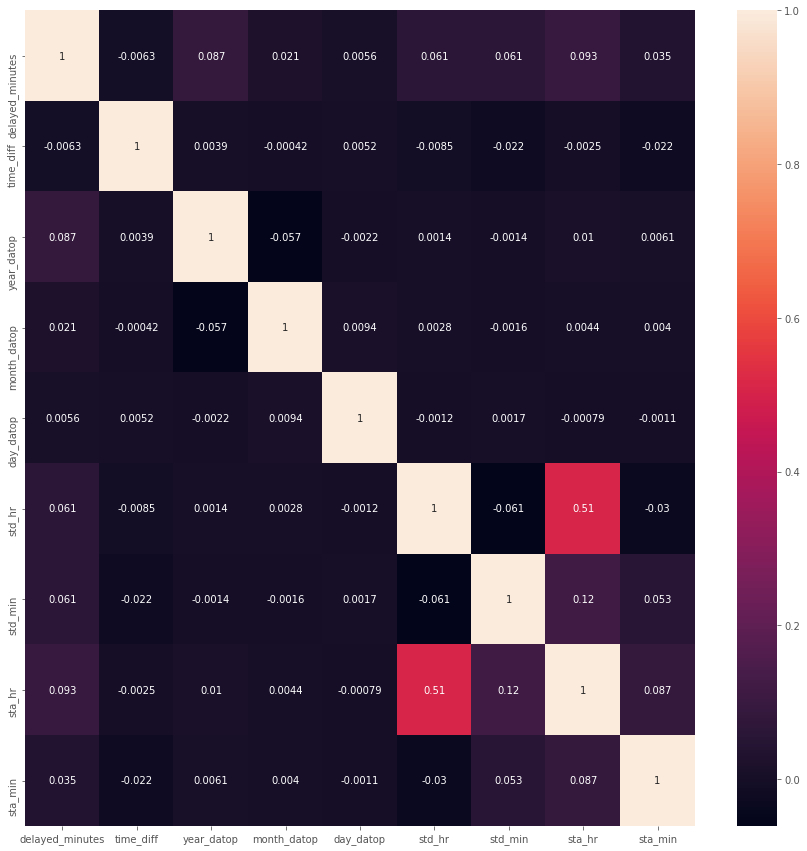

In [ ]:
#correlation 
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(),annot=True)
plt.savefig('Flight_corr_heatmap.png')

The variables that are most highly correlated are the Scheduled Time of Arrival Hour and Scheduled Time of Departure Hour with a correlation of 0.51

In [29]:
#Change the Season Datatype to Category
train['Season'] = train['Season'].astype('category')
test['Season'] = test['Season'].astype('category')

In [39]:
# Modelling
# Set X and y ie the independent and dependent variables
to_drop = ['id','delayed_minutes','Outcome','date_flight', 'scheduled_time_departure',	'scheduled_time_arrival']
features_columns = [col for col in train.columns if col not in to_drop]
X,y  = train[features_columns], train['delayed_minutes'].ravel()

categ_feat =np.where(X.dtypes == 'category')[0]
test_data = test.drop(columns=(['id','date_flight', 'scheduled_time_departure','scheduled_time_arrival']),axis=1)
#Cross validation
folds = KFold(n_splits = 10)
feature_importance_df = pd.DataFrame()

predictions = []
y_preds, y_trues = [], []
rmses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  
  wrapped_model = CatBoostRegressor(n_estimators=40000, eval_metric='RMSE',task_type= 'GPU', early_stopping_rounds=100)
 
  wrapped_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],cat_features=categ_feat, verbose = False)
  preds = wrapped_model.predict(test_data)
  y_pred = wrapped_model.predict(X_test)
  y_trues.extend(y_test)
  y_preds.extend(y_pred)
  predictions.append(preds)
  rmse = mean_squared_error(y_test, y_pred)**0.5
  print(i, rmse)
  rmses.append(rmse)
print(f'Mean RMSE: {np.mean(rmses)}')
mpreds = np.mean(predictions, 0)





0 86.14064450255624
1 90.01072683311257
2 86.54183940790566
3 122.01355803001873
4 124.32405035199929
5 138.19939553767074
6 78.43727107611848
7 141.8870882436999
8 139.52122116999178
9 127.52991726294626
Mean RMSE: 113.46057124160197


The RMSE is 113 minutes.

The feature importances are shown below:                   importance
feature                    
status               32.476
Season               15.750
flight_number        11.424
arrival_point         9.950
time_diff             9.831
departure_point       7.561
day_datop             5.334
aircraft_code         3.008
sta_hr                1.783
sta_min               1.482
std_min               0.894
std_hr                0.387
month_datop           0.120
year_datop            0.000


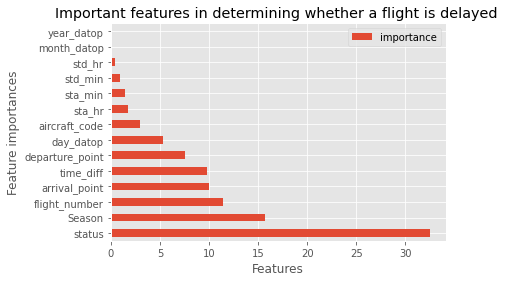

In [40]:

importances = pd.DataFrame({'feature':X.columns,'importance':np.round( wrapped_model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print("The feature importances are shown below: ",importances)
      # bar plot of the feature importances
      
importances.plot(kind = 'barh')
plt.title("Important features in determining whether a flight is delayed ")
plt.ylabel('Feature importances')
plt.xlabel('Features')
plt.show()

Some important features include Status,Season,Time_diff, Arrival_point and departure point.

**Conclusion**

Inorder to improve RMSE we need:

1.Some additional features like ratio of airport capacity and Tunisia's population can also be helpful

2.High level feature on departure time like 'early morning','morning','afternoon','evening','night' can be created.

3.Mean encoding of Categorical variables with smoothing can also be important where categorical values are large in number

4.Binning less occurring of values for some categorical variables

5.Data on whether Flights were direct or connecting flights

6.Removing Bias from dataset like some delays are unpredictable like delay eg Weather uncertainity or Weather data.

7.Hyperparameter Tuning can also be performed but as of now hardware resource (less computation power) is constraint.

8.Experiment with Ensemble, Stacking techniques can also be experimented to improve results.